In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

import nbimporter
import TwoDimensionalViewFactor as TDVF

Importing Jupyter notebook from TwoDimensionalViewFactor.ipynb


# 横型ブラインドの斜入射特性を計算するモジュール

スラット材の形状とスラットの日射反射率から任意のプロファイル角における横型ブラインドの日射透過率及び日射反射率を計算する。

### 入力値  

$ W $ ：スラット幅 (mm)  
$ d $ ：スラット高さ (mm)  
$ S $ ：スラット間隔 (mm)  
$ \rho_{upper,S} $：スラット材上面の日射反射率（鏡面反射成分）  
$ \rho_{upper,D} $：スラット材上面の日射反射率（拡散反射成分）  
$ \rho_{lower,S} $：スラット材下面の日射反射率（鏡面反射成分）  
$ \rho_{lower,D} $：スラット材下面の日射反射率（拡散反射成分）  
$ \psi $：スラット角 (°)  
$ \phi $：プロファイル角 (°)  

![image9.png][attached1]
[attached1]:img\image9.png  

### 出力値
$ \tau_{\phi,\psi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射透過率  
$ \rho_{\phi,\psi,f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率  
$ \tau_{\phi,\psi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射透過率  
$ \rho_{\phi,\psi,b} $ ：横型ブラインドの背面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率

### 計算方法  

#### データ構造と値の範囲  

$ W $・$ d $・$ S $・$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $・$ \psi $・$ \phi $の組み合わせをクラス『hbl＿input』と定義する。  
$ \rho_{upper,S} $・$ \rho_{upper,D} $・$ \rho_{lower,S} $・$ \rho_{lower,D} $の値は0.0以上1.0以下の値をとる。  
$ \psi $・$ \phi $の値は-90°以上90°以下の値をとる。  

In [2]:
class hbl_input():
    def __init__( self, W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi ):
        self.W = W
        self.d = d
        self.S = S
        self.REFUS = REFUS
        self.REFUD = REFUD
        self.REFLS = REFLS
        self.REFLD = REFLD
        self.psi = psi
        self.phi = phi

# W：スラット幅 (mm)
# d：スラット高さ (mm) 
# S：スラット間隔 (mm) 
# REFUS：スラット材上面の日射反射率（鏡面反射成分）
# REFUD：スラット材上面の日射反射率（拡散反射成分）
# REFLS：スラット材下面の日射反射率（鏡面反射成分）
# REFLD：スラット材下面の日射反射率（拡散反射成分）
# psi：スラット角 (°) 
# phi：プロファイル角 (°)

### 1. 日射透過率・日射反射率の計算

横型ブラインドの日射透過率と日射反射率の計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射透過率$ \tau_{\phi,\psi,f} $は、

$$
\begin{eqnarray}
 &\displaystyle \tau_{\phi, \psi, f} = \tau_{T, \phi, \psi, f} + \tau_{S, \phi, \psi, f} + \tau_{D, \phi, \psi, f}& \qquad\qquad\text{(1-1)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ \tau_{T, \phi, \psi, f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の直接日射透過率  
$ \tau_{S, \phi, \psi, f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の間接日射透過率（鏡面反射成分）  
$ \tau_{D, \phi, \psi, f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の間接日射透過率（拡散反射成分）

である。

背面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射透過率$ \tau_{\phi,\psi,b} $は、

$$
\begin{eqnarray}
 &\displaystyle \tau_{\phi, \psi, b} = \tau_{\phi, -\psi, f}& \qquad\qquad\text{(1-2)} \nonumber\\
\end{eqnarray}
$$

正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率$ \rho_{\phi,\psi,f} $は、

$$
\begin{eqnarray}
 &\displaystyle \rho_{\phi, \psi, f} = \rho_{S, \phi, \psi, f} + \rho_{D, \phi, \psi, f}& \qquad\qquad\text{(1-3)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ \rho_{S, \phi, \psi, f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率（鏡面反射成分）  
$ \rho_{D, \phi, \psi, f} $ ：横型ブラインドの正面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率（拡散反射成分）

である。

背面側からの入射光に対するプロファイル角$\phi$、スラット角$\psi$の日射反射率$ \rho_{\phi,\psi,b} $は、

$$
\begin{eqnarray}
 &\displaystyle \rho_{\phi, \psi, b} = \rho_{\phi, -\psi, f}& \qquad\qquad\text{(1-4)} \nonumber\\
\end{eqnarray}
$$

In [3]:
def total_optical_prop(tau_t, tau_s, tau_d, rho_s, rho_d):
    
    tau_tot = tau_t + tau_s + tau_d #式(1-1)
    rho_tot = rho_s + rho_d #式(1-3)
    
    return tau_tot, rho_tot    

### 2. 直接日射透過率

直接日射透過率$\tau_{T, \phi, \psi, f}$（入射日射のうちスラット材に当たらず直接透過する日射の成分比）の計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

![image10.png][attached1]
[attached1]:img\image10.png  


#### 入射日射（$l = 0$）の位置ベクトル、方向ベクトル、入射日射熱量  

![image7.png][attached1]
[attached1]:img\image7.png  

DA間の分割要素$m$からの入射日射の始点の位置ベクトル$ \boldsymbol{p}_{m,0} $は、

$$ 
\displaystyle \boldsymbol{p}_{m,0} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle (m + 0.5) \frac{S}{M} \\
\end{pmatrix} 
\qquad\qquad\text{(2-1)}
$$

ここで、  

$ \boldsymbol{p}_{m,l} $ ：入射開口DA間の分割要素$m$からの$l$回スラット材に反射した日射の始点の位置ベクトル  
$ M $ ：入射開口DA間の分割数  
$ l $ ：カウンタ（$0$～$l_{max}-1$）  
$ m $ ：カウンタ（$0$～$M-1$）  

である。

DA間の分割要素$m$からの入射日射の方向ベクトル$ \boldsymbol{s}_{m,0} $は、

$$ 
\displaystyle \boldsymbol{s}_{m,0} = 
\begin{pmatrix} 
\displaystyle \cos\phi \\
\displaystyle -\sin\phi \\
\end{pmatrix} 
\qquad\qquad\text{(2-2)}
$$

ここで、  

$ \boldsymbol{s}_{m,l} $ ：入射開口DA間の分割要素$m$からの$l$回スラット材に反射した日射の方向ベクトル  

である。

DA間の分割要素$m$からの入射日射熱量$ Q_{m,0} $は、

$$
\begin{eqnarray}
 &\displaystyle Q_{m,0} = I \cdot \cos \phi \cdot \Delta L_{m}& \qquad\qquad\text{(2-3)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ Q_{m,l} $ ：入射開口DA間の分割要素$m$からの$l$回スラット材に反射した日射熱量 (W/m)  
$ I $ ：法線面直達日射量（ここでは、光学計算のみであることから簡単のため、$I = 1$として計算する） (W/m)  
$ \Delta L_{m} $ ：入射開口DA間の分割要素$m$の長さ (m)    

である。

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{m} = \frac{S}{M}& \qquad\qquad\text{(2-4)} \nonumber\\
\end{eqnarray}
$$

#### 光線の始点の位置ベクトル（$l > 0$）の計算  

光線の始点の位置ベクトル$ \boldsymbol{p}_{m,l} $の計算式は、  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{p}_{m,l} = \boldsymbol{p}_{m,l-1} + a_{i} \cdot \boldsymbol{s}_{m,l-1} = \boldsymbol{q}_{i} + b_{i} \cdot \boldsymbol{v}_{i}& \qquad\qquad\text{(2-5)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ \boldsymbol{q}_{i} $ ：領域境界の分割要素$i$の始点の位置ベクトル（○章に計算方法を示す）  
$ \boldsymbol{v}_{i} $ ：領域境界の分割要素$i$の方向ベクトル（○章に計算方法を示す）    
$ a_{i},b_{i} $ ：分割要素$i$に日射が当たるか否かを判断する係数  
$ i $ ：カウンタ（$0$～$K-1$）  

である。

式(2-5)の関係より、

$$ 
\begin{pmatrix} 
\displaystyle s_{l-1,x}& -v_{i,x} \\
\displaystyle s_{l-1,y}& -v_{i,y} \\
\end{pmatrix}
\begin{pmatrix} 
\displaystyle a_{i} \\
\displaystyle b_{i} \\
\end{pmatrix}
=
\begin{pmatrix} 
\displaystyle q_{i,x} - p_{l-1,x} \\
\displaystyle q_{i,y} - p_{l-1,y} \\
\end{pmatrix}
\qquad\qquad\text{(2-6)}
$$

ただし、$0 < a_{i}$かつ$0 \leq b_{i} < 1$のとき、$\min a_{i}$が分割要素$i$に光線が到達する。

#### 直接日射透過率  

$l=0$の光線$m$が到達した領域境界の位置ベクトルすなわち、$l=1$の光線の始点の位置ベクトル$ \boldsymbol{p}_{1} $がBC間にあるとき、光線$m$がスラット間を直接透過したと判断する。したがって、プロファイル角$\phi$、スラット角$\psi$の直接日射透過率$\tau_{T, \phi, \psi}$は、  

$$
\begin{eqnarray}
 &\displaystyle \tau_{T, \phi, \psi} = \frac{\sum^{M-1}_{m=0}Q_{m,1(B \leq \boldsymbol{p}_{1} \leq C)}}{\sum^{M-1}_{m=0}Q_{m,0}}& \qquad\qquad\text{(2-7)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &Q_{m,1(B \leq \boldsymbol{p}_{1} \leq C)} = G_{\tau,m}Q_{m,0}& \qquad\qquad\text{(2-8)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ G_{\tau,m} $ ：光線$m$が直接透過したか判断する係数

であり、

$$
\begin{eqnarray}
 &\displaystyle G_{\tau,m} = \left\{ \begin{array}{ll}
    1 & (m \in BC) & \nonumber\\
                   & \qquad\qquad\qquad\text{(2-9)} \nonumber\\
    0 & (m \notin BC) & \nonumber\\
  \end{array}\right.
\end{eqnarray}
$$

式(2-9)と式(2-10)より、

$$
\begin{eqnarray}
 &\displaystyle \tau_{T, \phi, \psi} = \frac{\sum^{M-1}_{m=0}G_{\tau,m}}{M}& \qquad\qquad\text{(2-10)} \nonumber\\
\end{eqnarray}
$$

In [4]:
def through_transmission(L, M, q, v, u, sK):
    
    l = 1
    p = np.empty((M, 2, 2), dtype=object) #光線の始点の位置ベクトル
    s = np.zeros((M, 2, 2))               #光線の方向ベクトル
    ri = np.zeros(M)                      #光線の到達した領域境界分割要素
    G = np.zeros(M)                       #光線の最終到達面の判断

    for m in range(M):
        p[m][l-1] = [0., (m + 0.5) * L.S / M]                                        #式(2-1)、光線の始点の位置ベクトル(0回目)
        s[m][l-1] = [math.cos(math.radians(L.phi)), - math.sin(math.radians(L.phi))] #式(2-2)、光線の方向ベクトル(0回目)
        
        ra = 0. #raの初期化
        for i in range(sK[len(sK) - 2]): #A～D間で検索
            if np.vdot(s[m][l-1], u[i]) < 0.: #光線が表面から入射する
                detA = round(np.linalg.det(np.array([s[m][l-1], - v[i]]).T.astype(np.float64)), 10)
                if detA != 0.:
                    a = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                        (q[i] - p[m][l-1]).astype(np.float64))[0], 10)
                    b = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                        (q[i] - p[m][l-1]).astype(np.float64))[1], 10)
                    if 0. < a and 0. <= b and b < 1.:
                        if ra == 0. or a < ra: #aが最も小さい場合の領域境界分割要素に光線が到達する
                            ra = a    #光線が最初に到達する領域境界分割要素の判断用
                            ri[m] = i #光線の到達した領域境界分割要素

        if sK[2] <= ri[m] and ri[m] < sK[3]: G[m] = 1    #BC間(透過)
        
    tau_t = math.fsum(G) / M #式(2-11)

    return tau_t

### 3. 間接日射透過率・反射率（鏡面反射成分）

間接日射透過率・反射率（入射日射のうちスラット材に当たり反射したのち透過または反射する日射の成分比）のうち、鏡面反射成分の計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

![image11.png][attached1]
[attached1]:img\image11.png  

入射日射（$l = 0$）の位置ベクトル、方向ベクトル、入射日射熱量及び光線の始点の位置ベクトルの計算は、式(2-1)～式(2-6)による。

#### 光線の方向ベクトルの計算  

光線の方向ベクトル$ \boldsymbol{s}_{l} $の計算式は、  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{s}_{l} = - \boldsymbol{s}_{l-1} + 2 \frac{\boldsymbol{s}_{l-1} \cdot \boldsymbol{v}_{i}}{\bigl|\boldsymbol{v}_{i}\bigr|} \frac{\boldsymbol{v}_{i}}{\bigl|\boldsymbol{v}_{i}\bigr|}& \qquad\qquad\text{(3-1)} \nonumber\\
\end{eqnarray}
$$

式(3-1)の補足説明  

![image3.png][attached1]
[attached1]:img\image3.png  

$$
\begin{eqnarray}
 &\displaystyle c = \bigl|\boldsymbol{s}_{l-1}\bigr| \cos \xi& \qquad\qquad\text{(3-1-a)} \nonumber\\
\end{eqnarray}
$$

内積の関係より、

$$
\begin{eqnarray}
 &\displaystyle \cos \xi = \frac{\boldsymbol{s}_{l-1}\cdot \boldsymbol{v}_{i}}{\bigl|\boldsymbol{s}_{l-1}\bigr|\bigl|\boldsymbol{v}_{i}\bigr|}& \qquad\qquad\text{(3-1-b)} \nonumber\\
\end{eqnarray}
$$

式(3-1-a)と式(3-1-b)より、

$$
\begin{eqnarray}
 &\displaystyle c = \frac{\boldsymbol{s}_{l-1} \cdot \boldsymbol{v}_{i}}{\bigl|\boldsymbol{v}_{i}\bigr|}& \qquad\qquad\text{(3-1-c)} \nonumber\\
\end{eqnarray}
$$

次に、  

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{s}_{l} = -\boldsymbol{s}_{l-1} + 2c\frac{\boldsymbol{v}_{i}}{\bigl|\boldsymbol{v}_{i}\bigr|}& \qquad\qquad\text{(3-1-d)} \nonumber\\
\end{eqnarray}
$$

式(3-1-c)と式(3-1-d)より、式(3-1)が得られる。  

#### 間接日射透過率・反射率（鏡面反射成分）  

鏡面反射に対する日射透過率$\tau_{S, \phi, \psi}$は、  

$$
\begin{eqnarray}
 &\displaystyle \tau_{S, \phi, \psi} = \frac{\sum^{M-1}_{m=0}Q_{m,l(B \leq \boldsymbol{p}_{l} \leq C)}}{\sum^{M-1}_{m=0}Q_{m,0}}& \qquad\qquad\text{(3-2)} \nonumber\\
\end{eqnarray}
$$

光線$m$がスラット上面に$l_{m,upper,S}$回、スラット下面に$l_{m,lower,S}$回反射してBC間に到達した場合、

$$
\begin{eqnarray}
 &Q_{m,l(B \leq \boldsymbol{p}_{l} \leq C)} = G_{\tau,m}\:\rho_{upper,S}^{l_{m,upper,S}}\:\rho_{lower,S}^{l_{m,lower,S}}\:Q_{m,0}& \qquad\qquad\text{(3-3)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ G_{\tau,m} $ ：光線$m$が透過したか判断する係数  

である。  

光線$m$が直接透過せず1回以上スラット材で鏡面反射したのちBC間に到達した場合は$G_{\tau,m}=1$、それ以外の場合は$G_{\tau,m}=0$とする。  

式(3-2)と式(3-3)より、

$$
\begin{eqnarray}
 &\displaystyle \tau_{S, \phi, \psi} = \frac{\sum^{M-1}_{m=0}G_{\tau,m}\:\rho_{upper,S}^{l_{m,upper,S}}\:\rho_{lower,S}^{l_{m,lower,S}}}{M}& \qquad\qquad\text{(3-4)} \nonumber\\
\end{eqnarray}
$$

鏡面反射に対する日射反射率$ \rho_{S, \phi, \psi}$は、  

$$
\begin{eqnarray}
 &\displaystyle \rho_{S, \phi, \psi} = \frac{\sum^{M-1}_{m=0}Q_{m,l(D \leq \boldsymbol{p}_{l} \leq A)}}{\sum^{M-1}_{m=0}Q_{m,0}}& \qquad\qquad\text{(3-5)} \nonumber\\
\end{eqnarray}
$$

光線$m$がスラット上面に$l_{m,upper,S}$回、スラット下面に$l_{m,lower,S}$回反射してDA間に到達した場合、

$$
\begin{eqnarray}
 &Q_{m,l(D \leq \boldsymbol{p}_{l} \leq A)} = G_{\rho,m}\:\rho_{upper,S}^{l_{m,upper,S}}\:\rho_{lower,S}^{l_{m,lower,S}}\:Q_{m,0}& \qquad\qquad\text{(3-6)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ G_{\rho,m} $ ：光線$m$が反射したか判断する係数  

である。  

光線$m$が直接透過せず1回以上スラット材で鏡面反射したのちDA間に到達した場合は$G_{\rho,m}=1$、それ以外の場合は$G_{\rho,m}=0$とする。  

式(3-5)と式(3-6)より、

$$
\begin{eqnarray}
 &\displaystyle \rho_{S, \phi, \psi} = \frac{\sum^{M-1}_{m=0}G_{\rho,m}\:\rho_{upper,S}^{l_{m,upper,S}}\:\rho_{lower,S}^{l_{m,lower,S}}}{M}& \qquad\qquad\text{(3-7)} \nonumber\\
\end{eqnarray}
$$

In [5]:
def specular_reflection(L, M, q, v, u, lmax, sK):

    l = 0                                    #反射回数初期値
    p = np.empty((M, lmax, 2), dtype=object) #光線の始点の位置ベクトル
    s = np.zeros((M, lmax, 2))               #光線の方向ベクトル
    ri = np.empty((M, lmax), dtype=object)   #光線の到達した領域境界分割要素
    lupper = np.zeros(M)                     #スラット上面での反射回数
    llower = np.zeros(M)                     #スラット下面での反射回数
    G = np.zeros((M, 2))                     #光線の最終到達面の判断
    for m in range(M):
        p[m][0] = [0., (m + 0.5) * L.S / M]                                #式(2-1)、光線の始点の位置ベクトル(0回目) 
        s[m][0] = [math.cos(math.radians(L.phi)), - math.sin(math.radians(L.phi))] #式(2-2)、光線の方向ベクトル(0回目)
                
    while l <= lmax - 2 and not (s[:,l] == 0).all(): #全ての光線の方向ベクトルが0であれば計算終了
        l += 1 #反射回数の追加
        for m in range(M):
            ra = 0.
            rb = 0.
            for i in range(sK[len(sK) - 1] - 1):
                if not (l == 1. and sK[len(sK) - 2] <= i and i <= sK[len(sK) - 1] - 2):
                    if (s[m][l-1] == 0).all(): #光線の方向ベクトルが0であれば
                        ri[m][l] = ri[m][l-1]  #光線の到達した領域境界分割要素は前回と同じ
                    else:                      #光線の方向ベクトルが0でなければ
                        if i != ri[m][l-1] and np.vdot(s[m][l-1], u[i]) < 0.: #光線が同じ領域境界分割要素に到達したり、表面から入射しない場合スキップ
                            detA = round(np.linalg.det(np.array([s[m][l-1], - v[i]]).T.astype(np.float64)), 10)
                            if detA != 0.:
                                a = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                                    (q[i] - p[m][l-1]).astype(np.float64))[0], 10)
                                b = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                                    (q[i] - p[m][l-1]).astype(np.float64))[1], 10)
                                if 0. < a and 0. <= b and b < 1.:
                                    if ra == 0 or a < ra: #aが最も小さい場合の領域境界分割要素に光線が到達する
                                        ri[m][l] = i      #光線の到達した領域境界分割要素
                                        ra = a            #光線が最初に到達する領域境界分割要素の判断用
                                        rb = b            #光線の到達した位置ベクトル計算用

            if (sK[2] <= ri[m][l] and ri[m][l] < sK[3]) or (sK[6] <= ri[m][l] and ri[m][l] < (sK[7] - 1)):
                s[m][l] = 0 #光線がBC間またはDA間に到達した場合、光線の方向ベクトルを0とする処理
            else:
                s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ri[m][l]]) * v[ri[m][l]] / \
                          (v[ri[m][l]][0] ** 2. + v[ri[m][l]][1] ** 2.) #式(3-1)、光線の方向ベクトル(1回目以降)

            if (s[m][l-1] == 0).all(): #光線の方向ベクトルが0であれば
                p[m][l] = p[m][l-1]    #光線の始点の位置ベクトルは前回と同じ
            else:
                p[m][l] = q[ri[m][l]] + rb * v[ri[m][l]] #式(2-5)、光線の始点の位置ベクトル(1回目以降)

            if ri[m][l] < sK[0]:                                 llower[m] += 1 #AB間の下面A側
            elif sK[0] <= ri[m][l] and ri[m][l] < sK[1]:         lupper[m] += 1 #AB間の上面
            elif sK[1] <= ri[m][l] and ri[m][l] < sK[2]:         llower[m] += 1 #AB間の下面B側
            elif sK[2] <= ri[m][l] and ri[m][l] < sK[3]:
                if not (sK[2] <= ri[m][1] and ri[m][1] < sK[3]): G[m][0] = 1    #BC間(鏡面反射後の透過)
            elif sK[3] <= ri[m][l] and ri[m][l] < sK[4]:         lupper[m] += 1 #CD間の上面C側
            elif sK[4] <= ri[m][l] and ri[m][l] < sK[5]:         llower[m] += 1 #CD間の下面
            elif sK[5] <= ri[m][l] and ri[m][l] < sK[6]:         lupper[m] += 1 #CD間の上面D側
            elif sK[6] <= ri[m][l] and ri[m][l] < (sK[7] - 1):   G[m][1] = 1    #DA間(鏡面反射後の反射)
            #print (m,l,ri[m][l], p[m][l], s[m][l], ra, rb)

    attenuation = np.zeros(M)
    for m in range(M):
        attenuation[m] = L.REFUS ** lupper[m] * L.REFLS ** llower[m] #全入射光線の減衰率
        #print(m,lupper[m],llower[m], G[m][0], G[m][1], attenuation[m])

    tau_s = 0.
    rho_s = 0.
    for m in range(M):
        tau_s += attenuation[m] * G[m][0] / M #式(3-4)、透過
        rho_s += attenuation[m] * G[m][1] / M #式(3-7)、反射

    return tau_s, rho_s, p, s, l

### 4. 間接日射透過率・反射率（拡散反射成分）

間接日射透過率・反射率（入射日射のうちスラット材に当たり反射したのち透過または反射する日射の成分比）のうち、拡散反射成分の計算方法を以下に示す。  

（参考：JIS A 2103：2014 附属書C ブラインドの光学特性の計算方法）  

![image12.png][attached1]
[attached1]:img\image12.png  

入射日射（$l = 0$）の位置ベクトル、方向ベクトル、入射日射熱量及び光線の始点の位置ベクトルの計算は、式(2-1)～式(2-8)による。

#### 直接受照日射量の計算

直接受照日射量$E_{d,i}$の計算式は、

$$
\begin{eqnarray}
 &\displaystyle E_{d,i} = \sum^{M-1}_{m=0} \frac {Q_{m,0} \sin \xi_{i}}{\Delta L_{i}}& \qquad\qquad\text{(4-1)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ E_{d,i} $ ：領域境界分割要素$i$の直接受照日射量 (W/m)  
$ \xi_{i} $ ：入射日射（$l=0$）の方向ベクトル$\boldsymbol{s}_{0}$と領域境界分割要素$i$の方向ベクトル$\boldsymbol{v}_{i}$が成す角度 (°)  
$ \Delta L_{i} $ ：領域境界分割要素$i$の長さ (m)  

である。  

$$
\begin{eqnarray}
 &\displaystyle \xi_{i} = \arccos \frac{\boldsymbol{s}_{0}\cdot \boldsymbol{v}_{i}}{\bigl|\boldsymbol{s}_{0}\bigr|\bigl|\boldsymbol{v}_{i}\bigr|}& \qquad\qquad\text{(4-2)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{i} = \bigl|\boldsymbol{q}_{i+1} - \boldsymbol{q}_{i}\bigr|& \qquad\qquad\text{(4-3)} \nonumber\\
\end{eqnarray}
$$

![image3.png][attached1]
[attached1]:img\image3.png  

#### 間接受照日射量の計算

間接受照日射量$E_{r,i}$の計算式は、

$$
\begin{eqnarray}
 &\displaystyle E_{r,i} \Delta L_{i} = \sum^{K-1}_{j=0} F_{ji}\rho_{j,D} (E_{r,j} + E_{d,j}) \Delta L_j& \qquad\qquad\text{(4-4)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ E_{r,i} $ ：領域境界分割要素$i$の間接受照日射量 (W/m)  
$ F_{ji} $ ：領域境界分割要素$j$から$i$をみる形態係数  
$ \rho_{j,D} $ ：領域境界分割要素$j$の日射反射率（拡散反射成分）  
$ E_{r,j} $ ：領域境界分割要素$j$の間接受照日射量 (W/m)  
$ E_{d,j} $ ：領域境界分割要素$j$の直接受照日射量 (W/m)  
$ \Delta L_{j} $ ：領域境界分割要素$j$の長さ (m)  

である。  

形態係数の相反則より、

$$
\begin{eqnarray}
 &\displaystyle \Delta L_{i} F_{ij} = \Delta L_{j} F_{ji}& \qquad\qquad\text{(4-5)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ F_{ij} $ ：領域境界分割要素$i$から$j$をみる形態係数（2次元形態係数を計算するモジュールによる）  

である。  

式(4-4)と式(4-5)より、

$$
\begin{eqnarray}
 &\displaystyle E_{r,i} = \sum^{K-1}_{j=0} F_{ij}\rho_{j,D} E_{r,j} + \sum^{K-1}_{j=0} F_{ij}\rho_{j,D} E_{d,j}& \qquad\qquad\text{(4-6)} \nonumber\\
\end{eqnarray}
$$

全領域境界について考えると、

$$
\begin{eqnarray}
 &\displaystyle \sum^{K-1}_{i=0}E_{r,i} = \sum^{K-1}_{i=0}\sum^{K-1}_{j=0} F_{ij}\rho_{j,D} E_{r,j} + \sum^{K-1}_{i=0}\sum^{K-1}_{j=0} F_{ij}\rho_{j,D} E_{d,j}& \qquad\qquad\text{(4-7)} \nonumber\\
\end{eqnarray}
$$

式(4-7)を変形すると、

$$
\begin{eqnarray}
 &\displaystyle \sum^{K-1}_{i=0}\sum^{K-1}_{j=0} (\delta_{i,j} - F_{ij}\rho_{j,D}) E_{r,j} = \sum^{K-1}_{i=0}\sum^{K-1}_{j=0} F_{ij}\rho_{j,D} E_{d,j}& \qquad\qquad\text{(4-8)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ \delta_{i,j} $ ：クロネッカーのデルタ（$i=j$のとき$1$、$i \neq j$のとき$0$）  

である。  

式(4-8)を行列表現すると、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{A} \boldsymbol{E}_{r} = \boldsymbol{B} \boldsymbol{E}_{d}& \qquad\qquad\text{(4-9)} \nonumber\\
\end{eqnarray}
$$

ここで、  

$ A_{i,j} = \delta_{i,j} - F_{ij}\rho_{j,D} $  

$ B_{i,j} = F_{ij}\rho_{j,D} $  

である。  

よって、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{E}_{r} = \boldsymbol{A} ^{-1} \boldsymbol{B} \boldsymbol{E}_{d}& \qquad\qquad\text{(4-10)} \nonumber\\
\end{eqnarray}
$$

領域境界分割要素$j$の日射反射率（拡散反射成分）$\rho_{j,D}$は、

$$
\begin{eqnarray}
 &\displaystyle \rho_{j,D} = \left\{ \begin{array}{ll}
    \rho_{upper,D} & (j \in AB_{upper}, j \in CD_{upper}) & \nonumber\\
    \rho_{lower,D} & (j \in AB_{lower}, j \in CD_{lower}) & \qquad\qquad\text{(4-11)} \nonumber\\
    0 & (j \in BC, j \in DA) & \nonumber\\
  \end{array}\right.
\end{eqnarray}
$$

#### 間接日射透過率・反射率（拡散反射成分）  

拡散反射に対する日射透過率$\tau_{D, \phi, \psi}$は、  

$$
\begin{eqnarray}
 &\displaystyle \tau_{D, \phi, \psi} = \frac{\sum_{i \in BC}E_{r,i}\Delta L_{i}}{\sum^{M-1}_{m=0}Q_{m,0}}& \qquad\qquad\text{(4-12)} \nonumber\\
\end{eqnarray}
$$

拡散反射に対する日射反射率$ \rho_{D, \phi, \psi}$は、  

$$
\begin{eqnarray}
 &\displaystyle \rho_{D, \phi, \psi} = \frac{\sum_{i \in DA}E_{r,i}\Delta L_{i}}{\sum^{M-1}_{m=0}Q_{m,0}}& \qquad\qquad\text{(4-13)} \nonumber\\
\end{eqnarray}
$$

In [6]:
def distance_calc(A, B):
    return ((A[0] - B[0]) ** 2. + (A[1] - B[1]) ** 2.) ** 0.5

In [7]:
def diffuse_reflection(L, M, q, v, u, sK):
    
    Q = np.empty((M, 2), dtype=object)                         #入射開口DA間の分割要素mからの入射日射熱量(W/m)
    p = np.empty((M, 2, 2), dtype=object)                      #光線の始点の位置ベクトル
    s = np.zeros((M, 2, 2))                                    #光線の方向ベクトル
    dLm = np.zeros(M)                                          #光線の分割要素の長さ(m)
    ri = np.empty(M, dtype=object)                             #光線の到達した領域境界分割要素
    I = 1.                                                     #日射強度(W/m)
    xi = np.zeros(sK[len(sK) - 1] - 1)
    Ed = np.zeros(sK[len(sK) - 1] - 1)                         #直接受照日射量
    Er = np.zeros(sK[len(sK) - 1] - 1)                         #間接受照日射量
    rhod = np.zeros(sK[len(sK) - 1] - 1)                       #領域境界分割要素の日射反射率(拡散反射成分)
    
    tvf_in = TDVF.tvf_input(q)
    F = TDVF.two_dimensional_view_factor(tvf_in)
    dLi = np.array([distance_calc(q[i+1], q[i]) for i in range(sK[len(sK) - 1] - 1)], dtype=float)
                                            
    #式(4-11)、領域境界要素毎の日射反射率
    for j in range(sK[len(sK) - 1] - 1):
        if j < sK[0]:                        rhod[j] = L.REFLD #AB間の下面A側
        elif sK[0] <= j and j < sK[1]:       rhod[j] = L.REFUD #AB間の上面
        elif sK[1] <= j and j < sK[2]:       rhod[j] = L.REFLD #AB間の下面B側
        elif sK[2] <= j and j < sK[3]:       rhod[j] = 0.      #BC間
        elif sK[3] <= j and j < sK[4]:       rhod[j] = L.REFUD #CD間の上面C側
        elif sK[4] <= j and j < sK[5]:       rhod[j] = L.REFLD #CD間の下面
        elif sK[5] <= j and j < sK[6]:       rhod[j] = L.REFUD #CD間の上面D側
        elif sK[6] <= j and j < (sK[7] - 1): rhod[j] = 0.      #DA間            
                    
    sumQ = 0.
    for l in range(2):
        for m in range(M):
            if l == 0:
                p[m][l] = [0, (m + 0.5) * L.S / M]                                #式(2-1)、光線の始点の位置ベクトル(0回目) 
                s[m][l] = [math.cos(math.radians(L.phi)), - math.sin(math.radians(L.phi))] #式(2-2)、光線の方向ベクトル(0回目)
                dLm[m] = L.S / M                                                  #式(2-4)、分割要素mの長さ#追加
                Q[m][l] = I * math.cos(math.radians(L.phi)) * dLm[m]                  #式(2-3)、光線の入射日射熱量(0回目)#追加
                sumQ += Q[m][l]
            elif l ==1:
                ra = 0
                for i in range(sK[len(sK) - 2]): #A～D間で検索
                    if np.vdot(s[m][l-1], u[i]) < 0.: #光線が表面から入射しない場合スキップ
                        detA = round(np.linalg.det(np.array([s[m][l-1], - v[i]]).T.astype(np.float64)), 10)
                        if detA != 0.:
                            a = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                                (q[i] - p[m][l-1]).astype(np.float64))[0], 10)
                            b = round(np.linalg.solve(np.array([s[m][l-1], - v[i]]).T.astype(np.float64), \
                                (q[i] - p[m][l-1]).astype(np.float64))[1], 10)
                            if 0 < a and 0 <= b and b < 1:
                                if ra == 0 or a < ra: #aが最も小さい場合の領域境界分割要素に光線が到達する
                                    ri[m] = i #光線の到達した領域境界分割要素
                                    ra = a    #光線が最初に到達する領域境界分割要素の判断用
                                
                if (sK[2] <= ri[m] and ri[m] < sK[3]) or (sK[6] <= ri[m] and ri[m] < (sK[7] - 1)):
                    s[m][l] = 0 #光線がBC間またはDA間に到達した場合、光線の方向ベクトルを0とする処理
                else:
                    s[m][l] = -s[m][l-1] + 2 * np.vdot(s[m][l-1], v[ri[m]]) * v[ri[m]] / \
                              (v[ri[m]][0] ** 2. + v[ri[m]][1] ** 2.) #式(3-1)、光線の方向ベクトル(1回目以降)
                    xi[ri[m]] = math.degrees(np.arccos(np.vdot(s[m][l], v[ri[m]]) / \
                                ((s[m][l][0] ** 2. + s[m][l][1] ** 2.) ** 0.5 * \
                                (v[ri[m]][0] ** 2. + v[ri[m]][1] ** 2.) ** 0.5))) #式(4-2)、#追加
                    #Ed[ri[m]] += Q[m][l-1] * math.sin(math.radians(xi[ri[m]])) / dLi[ri[m]] #式(4-1)、#追加
                    Ed[ri[m]] += Q[m][l-1] * 1 / dLi[ri[m]] #式(4-1)、#追加
            
    Kdelta = np.identity(sK[len(sK) - 1] - 1)                  #クロネッカーのデルタ
    A = np.array([[Kdelta[i][j] - F[i][j] * rhod[j] \
                   for j in range(sK[len(sK) - 1] - 1)] for i in range(sK[len(sK) - 1] - 1)], dtype=float)
    B = np.array([[F[i][j] * rhod[j] \
                   for j in range(sK[len(sK) - 1] - 1)] for i in range(sK[len(sK) - 1] - 1)], dtype=float)
            
    if np.linalg.det(A) != 0:    
        inv_A = np.linalg.inv(A) #Aの逆行列

    Er = np.dot(np.dot(inv_A, B), Ed) #式(4-10)

    tau_d = 0.
    rho_d = 0.    
    for i in range(sK[len(sK) - 1] - 1):
        if sK[2] <= i and i < sK[3]:
            tau_d += Er[i] * dLi[i] / sumQ
        elif sK[6] <= i and i < (sK[7] - 1):
            rho_d += Er[i] * dLi[i] / sumQ
            
    return tau_d, rho_d

### 5. 領域境界分割要素の位置ベクトルと方向ベクトル

#### スラット端点と中央点の位置

点A(下スラットの左端点)、点B(下スラットの右端点)、点C(上スラットの右端点)、点D(上スラットの左端点)、点E(下スラットの中央点)、点F(上スラットの中央点)の位置ベクトルは、

![image4.png][attached1]
[attached1]:img\image4.png  

$$ 
\displaystyle \boldsymbol{A} = 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle 0 \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$$ 
\displaystyle \boldsymbol{B} = 
\begin{pmatrix} 
\displaystyle W\cos\psi \\
\displaystyle W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(2)}
$$

$$ 
\displaystyle \boldsymbol{C} = 
\begin{pmatrix} 
\displaystyle B_{x} \\
\displaystyle B_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(3)}
$$

$$ 
\displaystyle \boldsymbol{D} = 
\begin{pmatrix} 
\displaystyle A_{x} \\
\displaystyle A_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

平板スラット($d=0$)の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{E} = \frac{\boldsymbol{B} - \boldsymbol{A}}{2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

円弧スラット($d \neq 0$)の場合、

$$ 
\displaystyle \boldsymbol{E} = 
\begin{pmatrix} 
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigl) \\
\end{pmatrix} 
\qquad\qquad\text{(6)}
$$

$$ 
\displaystyle \boldsymbol{F} = 
\begin{pmatrix} 
\displaystyle E_{x} \\
\displaystyle E_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(7)}
$$

In [8]:
def slat_edge_position(L):
    
    A = np.array([0., 0.]) #式(1)
    B = np.array([L.W * math.cos(math.radians(L.psi)), L.W * math.sin(math.radians(L.psi))]) #式(2)
    C = np.array([B[0], B[1] + L.S]) #式(3)
    D = np.array([A[0], A[1] + L.S]) #式(4)
    if L.d ==0:
        E = (B - A) / 2. #式(5)
    else:
        E = np.array([((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * math.cos(np.arctan(L.d / (0.5 * L.W)) + math.radians(L.psi)), 
                      ((0.5 * L.W) ** 2. + L.d ** 2.) ** 0.5 * math.sin(np.arctan(L.d / (0.5 * L.W)) + math.radians(L.psi))]) #式(6)
    
    F = np.array([E[0], E[1] + L.S]) #式(7)
    
    return A, B, C, D, E, F

#### 円弧スラットの中心座標、半径、中心角  

円弧スラット($d \neq 0$)の場合、  

円の方程式  

$$
\begin{eqnarray}
 &\displaystyle x^2 + y^2 + l_0x + l_1y + l_2 = 0& \qquad\qquad\text{(1)} \nonumber\\
\end{eqnarray}
$$

式(1)を変形すると、  

$$
\begin{eqnarray}
 &\displaystyle l_0x + l_1y + l_2 = -(x^2 + y^2)& \qquad\qquad\text{(2)} \nonumber\\
\end{eqnarray}
$$

外接円となる点A、点B、点Eの3点の位置ベクトルを式(2)に代入して連立すると、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{a} \cdot \boldsymbol{l} = \boldsymbol{b}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

ここで、

$ 
\displaystyle \boldsymbol{a} = 
\begin{pmatrix} 
\displaystyle 0&\displaystyle 0&\displaystyle 1 \\
\displaystyle W\cos\psi&\displaystyle W\sin\psi&\displaystyle 1 \\
\displaystyle \sqrt{(0.5W)^2 + d^2} \cos\Bigl(\arctan\frac{d}{0.5W} +\psi\Bigr)&\displaystyle \sqrt{(0.5W)^2 + d^2} \sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)&\displaystyle 1 \\
\end{pmatrix} 
$  

$
\displaystyle \boldsymbol{l}
=
\begin{pmatrix} 
\displaystyle l_0 \\
\displaystyle l_1 \\
\displaystyle l_2 \\
\end{pmatrix}
$  

$
\displaystyle \boldsymbol{b}
= 
\begin{pmatrix} 
\displaystyle 0 \\
\displaystyle -(W\cos\psi^2 + \sin\psi^2) \\
\displaystyle -\Biggl(\biggl(\sqrt{(0.5W)^2 + d^2}\cos\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2 + 
               \biggl(\sqrt{(0.5W)^2 + d^2}\sin\Bigl(\arctan\frac{d}{0.5W} + \psi\Bigr)\biggr)^2\Biggr) \\
\end{pmatrix} 
$  

外接円の中心点Oの位置ベクトルは、

$$ 
\displaystyle \boldsymbol{O} = 
\begin{pmatrix} 
\displaystyle -0.5l_0 \\
\displaystyle -0.5l_1 \\
\end{pmatrix}
\qquad\qquad\text{(4)}
$$

外接円の半径$r$は、

$$
\begin{eqnarray}
 &\displaystyle r = \sqrt{(-0.5l_0) ^ 2 + (-0.5l_1) ^ 2 - l_2}& \qquad\qquad\text{(5)} \nonumber\\
\end{eqnarray}
$$

点Aと点Bがなす円弧の中心角$\theta$は、

$$
\begin{eqnarray}
 &\displaystyle \theta = 4 \arctan \frac{d}{0.5W}& \qquad\qquad\text{(6)} \nonumber\\
\end{eqnarray}
$$

In [9]:
#3点を通る外接円の点A、点B、点E及び中心点Oの座標、半径r、中心角θ
def slat_circle(L, A, B, E):
    
    if L.d == 0:
        O = ''
        r = ''
        theta = ''
    else:
        a = (np.array([[A[0], A[1], 1.], [B[0], B[1], 1.], [E[0], E[1], 1.]])).astype(np.float64)
        b = (-(a[:, 0] ** 2 + a[:, 1] ** 2.)).astype(np.float64)
        l = np.linalg.solve(a, b) #式(3)

        O =[- 0.5 * l[0], - 0.5 * l[1]] #円弧の原点の位置ベクトル 式(4)
        r = ((- 0.5 * l[0]) ** 2. + (- 0.5 * l[1]) ** 2. - l[2]) ** 0.5 #式(5)
        theta = math.degrees(4 * np.arctan(L.d / (0.5 * L.W))) #円弧の中心角 式(6)
    
    return O, r, theta

#### スラットの最端座標  

円弧スラット($d \neq 0$)かつ$ O_{y} > A_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{A}' = 
\begin{pmatrix} 
\displaystyle O_{x} - r \\
\displaystyle O_{y} \\
\end{pmatrix}
\qquad\qquad\text{(1)}
$$

円弧スラット($d \neq 0$)かつ$ O_{y} > B_{y} $の場合、 

$$ 
\displaystyle \boldsymbol{B}' = 
\begin{pmatrix} 
\displaystyle O_{x} + r \\
\displaystyle O_{y} \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

その他の場合、

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{A}' = \boldsymbol{A}& \qquad\qquad\text{(3)} \nonumber\\
\end{eqnarray}
$$

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{B}' = \boldsymbol{B}& \qquad\qquad\text{(4)} \nonumber\\
\end{eqnarray}
$$

$$ 
\displaystyle \boldsymbol{C}' = 
\begin{pmatrix} 
\displaystyle B'_{x} \\
\displaystyle B'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(5)}
$$

$$ 
\displaystyle \boldsymbol{D}' = 
\begin{pmatrix} 
\displaystyle A'_{x} \\
\displaystyle A'_{y} + S \\
\end{pmatrix}
\qquad\qquad\text{(6)}
$$

In [10]:
def slat_additional_position(L, O, r, A, B):
    
    if L.d == 0:
        Ad = A
        Bd = B
    else:
        if O[1] > A[1]: #円弧が食い込む
            Ad = np.array([O[0] - r, O[1]]) #点A'の位置
        else:           #円弧が食い込まない
            Ad = A                          #点A'の位置

        if O[1] > B[1]: #円弧が食い込む
            Bd = np.array([O[0] + r, O[1]]) #点B'の位置
        else:           #円弧が食い込まない
            Bd = B                          #点B'の位置
    Cd = np.array([Bd[0], Bd[1] + L.S]) #点C'の位置
    Dd = np.array([Ad[0], Ad[1] + L.S]) #点D'の位置
    
    return Ad, Bd, Cd, Dd

#### 平板スラットの領域境界分割要素の始点の位置ベクトル 

![image8.png][attached1]
[attached1]:img\image8.png  

平板スラット($d=0$)の領域境界分割要素の始点の位置ベクトル$\boldsymbol{q}_i$は、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle \frac{i}{K_0} W \cos \psi \\
\displaystyle \frac{i}{K_0} W \sin \psi \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 < i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{K_0,x} \\
\displaystyle q_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) < i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1),x} - \frac{i - K_0 - K_1 - K_2}{K_2} W\cos\psi \\
\displaystyle q_{(K_0 + K_1),y} - \frac{i - K_0 - K_1 - K_2}{K_2} W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) < i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1 + K_2),x} \\
\displaystyle q_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3} S \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [11]:
#平板スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_flat_q(L, K):
    
    sK = np.array([np.sum(K[:i+1]) for i in range(len(K))], dtype=int)
    
    q = np.empty((sK[len(K)-1] + 1, 2), dtype=object)
    for i in range(sK[len(K)-1] + 1):
        if L.d == 0: #平板
            if i <= sK[0]:   #A-B間
                q[i] = [i / K[0] * L.W * math.cos(math.radians(L.psi)), 
                        i / K[0] * L.W * math.sin(math.radians(L.psi))]
            elif i <= sK[1]: #B-C間
                q[i] = [q[sK[0]][0], 
                        q[sK[0]][1] + (i - sK[0]) / K[1] * L.S]
            elif i <= sK[2]: #C-D間
                q[i] = [q[sK[1]][0] - (i - sK[1]) / K[2] * L.W * math.cos(math.radians(L.psi)), 
                        q[sK[1]][1] - (i - sK[1]) / K[2] * L.W * math.sin(math.radians(L.psi))]
            elif i <= sK[3]: #D-A間
                q[i] = [q[sK[2]][0], 
                        q[sK[2]][1] - (i - sK[2]) / K[3] * L.S]
                
    Kn = np.array([0, K[0], 0, K[1], 0, K[2], 0, K[3] + 1])
    sKn = np.array([np.sum(Kn[:i+1]) for i in range(len(Kn))], dtype=int)
                             
    return q, sKn

#### 円弧スラットの領域境界分割要素の始点の位置ベクトル 

円弧スラット($d \neq 0$)の領域境界分割要素の始点の位置ベクトル$\boldsymbol{q}_i$は、次のように表すことができる。  

$0 \leq i \leq K_0$の場合、

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle O_x - r \cos\Bigl(\arctan\frac{O_y}{O_x} - \frac{i}{K_0} \theta \Bigr) \\
\displaystyle O_y - r \sin\Bigl(\arctan\frac{O_y}{O_x} - \frac{i}{K_0} \theta \Bigr) \\
\end{pmatrix} 
\qquad\qquad\text{(1)}
$$

$K_0 \leq i \leq (K_0 + K_1)$の場合、  

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{K_0,x} \\
\displaystyle q_{K_0,y} + \frac{i - K_0}{K_1} S \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

$(K_0 + K_1) \leq i \leq (K_0 + K_1 + K_2)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1),x} + O_x - r\cos\Bigl(\arctan\frac{O_y}{O_x} + \frac{i - K_0 - K_1 - K_2}{K_2} \theta \Bigr) - W\cos\psi \\
\displaystyle q_{(K_0 + K_1),y} + O_y - r\sin\Bigl(\arctan\frac{O_y}{O_x} + \frac{i - K_0 - K_1 - K_2}{K_2} \theta \Bigr) - W\sin\psi \\
\end{pmatrix} 
\qquad\qquad\text{(3)}
$$

$(K_0 + K_1 + K_2) \leq i \leq (K_0 + K_1 + K_2 + K_3)$の場合、 

$$ 
\displaystyle \boldsymbol{q}_i = 
\begin{pmatrix} 
\displaystyle q_{(K_0 + K_1 + K_2),x} \\
\displaystyle q_{(K_0 + K_1 + K_2),y} - \frac{i - K_0 - K_1 - K_2}{K_3} S \\
\end{pmatrix} 
\qquad\qquad\text{(4)}
$$

In [12]:
#円弧スラットの領域境界の分割要素の始点の位置ベクトル
def position_vector_curve_qd(L, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd):

    qd = np.empty((len(K), max(K) + 1, 2), dtype=object)

    for k in range(len(K)):
        for i in range(K[k] + 1):
            if k == 0: #A-B間
                if O[0] >= A[0]: pns = - 1.
                elif O[0] < A[0]: pns = 1.

                qd[k][i] = [O[0] + pns * r * math.cos((np.arctan(O[1] / O[0])) - math.radians(i / K[0] * theta)), 
                            O[1] + pns * r * math.sin((np.arctan(O[1] / O[0])) - math.radians(i / K[0] * theta))] #式(1)
            
            elif k == 1: #B-C間
                if (B == Bd).all(): sp = qd[0][K[0]]
                else: sp = Bd

                qd[k][i] = [sp[0], 
                            sp[1] + i / K[1] * L.S] #式(2)
                
            elif k == 2: #C-D間
                if (C == Cd).all(): sp = qd[1][K[1]]
                else: sp = C

                if O[0] >= A[0]: pns = - 1.
                elif O[0] < A[0]: pns = 1.

                qd[k][i] = [sp[0] + O[0] + pns * r * math.cos((np.arctan(O[1] / O[0])) + \
                            math.radians((i - K[2]) / K[2] * theta)) - L.W * math.cos(math.radians(L.psi)), 
                            sp[1] + O[1] + pns * r * math.sin((np.arctan(O[1] / O[0])) + \
                            math.radians((i - K[2]) / K[2] * theta)) - L.W * math.sin(math.radians(L.psi))] #式(3)
                
            elif k == 3: #D-A間
                if (D == Dd).all(): sp = qd[2][K[2]]
                else: sp = Dd

                qd[k][i] = [sp[0], 
                            sp[1] - i / K[3] * L.S] #式(4)

    return qd

In [13]:
#領域内・外点の判断(回転角で判断すべきか？？)
def position_specific_qd(L, K, qd, A, B, C, D, Ad, Bd, Cd, Dd):
    
    out_pt = np.zeros(len(qd), dtype=int)
    in_pt = np.zeros(len(qd), dtype=int) 
        
    for k in range(len(K)):
        for i in range(K[k] + 1):
            if k == 0: #A-B間
                if (A != Ad).all() and qd[k][i][0] < B[0]:
                    if L.d > 0 and qd[k][i][1] < Ad[1]:
                        out_pt[0] += 1 #点A-A'間の領域外点
                    elif L.d < 0 and qd[k][i][1] > Ad[1]:
                        in_pt[0] += 1  #点A-A'間の領域内点

                if (B != Bd).all() and qd[k][i][0] > A[0]:
                    if L.d > 0 and qd[k][i][1] < Bd[1]:
                        out_pt[1] += 1 #点B-B'間の領域外点
                    elif L.d < 0 and qd[k][i][1] > Bd[1]:
                        in_pt[1] += 1  #点B-B'間の領域内点

            if k == 2: #C-D間
                if (C != Cd).all() and qd[k][i][0] > D[0]:
                    if L.d > 0 and qd[k][i][1] < Cd[1]:
                        in_pt[2] += 1 #点C-C'間の領域内点
                    elif L.d < 0 and qd[k][i][1] > Cd[1]:
                        out_pt[2] += 1  #点C-C'間の領域外点 
                    
                if (D != Dd).all() and qd[k][i][0] < C[0]:
                    if L.d > 0 and qd[k][i][1] < Dd[1]:
                        in_pt[3] += 1 #点D-D'間の領域内点
                    elif L.d < 0 and qd[k][i][1] > Dd[1]:
                        out_pt[3] += 1  #点D-D'間の領域外点
                    
    return out_pt, in_pt

In [14]:
#領域外点の削除・追加
def position_vector_curve_q(L, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt):
    
    Kn = np.array([in_pt[0], K[0] - (out_pt[0] + out_pt[1]), in_pt[1], K[1], 
                   in_pt[2], K[2] - (out_pt[2] + out_pt[3]), in_pt[3], K[3] + 1])

    
    if out_pt[0] != 0 or out_pt[1] != 0: Kn[1] = K[0] + 1 - (out_pt[0] + out_pt[1])
    if out_pt[2] != 0 or out_pt[3] != 0: Kn[6] = K[2] + 1 - (out_pt[2] + out_pt[3])
        
    sKn =np.zeros(len(Kn), dtype=int)
    for i in range(len(Kn)):
        sKn[i] = np.sum(Kn[:i+1])

    qn = np.empty((sKn[len(Kn)-1], 2), dtype=object) 
    
    for i in range(sKn[len(Kn)-1]):
        if i < sKn[0]: #d<0でなければ存在しない
            qn[i] = " "
            
        elif i < sKn[1]: #A-B間
            if out_pt[0] == 0:
                qn[i] = qd[0, i] 
            else:
                if i == 0:
                    qn[i] = Ad
                else:
                    qn[i] = qd[0, i - 1 + out_pt[0]]
            
        elif i < sKn[2]: #d<0でなければ存在しない
            qn[i] = " "
            
        elif i < sKn[3]: #B-C間
            qn[i] = qd[1, i - sKn[2]]
            
        elif i < sKn[4]: #上スラット上面右
            if in_pt[2] != 0:
                if i - sKn[3] == 0:
                    qn[i] = Cd
                else:
                    qn[i] = qd[2, sKn[4] - i]
            
        elif i < sKn[5]: #C-D間
            qn[i] = qd[2, i - sKn[4]]
            
        elif i < sKn[6]: #上スラット上面左
            if in_pt[3] != 0:               
                qn[i] = qd[2, sKn[5] + Kn[5] - i]
            
        elif i < sKn[7]: #D-A間
            qn[i] = qd[3, i - sKn[6]]
            
    for i in range(sKn[len(Kn)-1]):
        qn[i] -= Ad

    return qn, sKn

#### 境界分割要素の方向ベクトル と法線ベクトル 

領域境界分割要素の方向ベクトル$\boldsymbol{v}_i$は、次のように表すことができる。 

$$
\begin{eqnarray}
 &\displaystyle \boldsymbol{v}_i = \boldsymbol{q}_{i+1} - \boldsymbol{q}_i& \qquad\qquad\text{(1)} \nonumber\\
\end{eqnarray}
$$

方向ベクトル$\boldsymbol{v}_i$の法線ベクトル（反時計回りに90°回転した方向ベクトル）$\boldsymbol{u}_i$は、次のように表すことができる。

$$ 
\displaystyle \boldsymbol{u}_i = 
\begin{pmatrix} 
\displaystyle - v_{i,y} \\
\displaystyle v_{i,x} \\
\end{pmatrix}
\qquad\qquad\text{(2)}
$$

In [15]:
def direction_vector(q):
        
    v = np.array([q[i+1] - q[i] for i in range(len(q) - 1)], dtype=float)       #領域境界分割要素の方向ベクトル
    u = np.array([[-v[i][1], v[i][0]] for i in range(len(q) - 1)], dtype=float) #vの法線ベクトル
        
    return v, u

#### Example

0.0 75.0 0.0 1.0 0.0 1.0 0.24000000000000007 0.7600000000000005


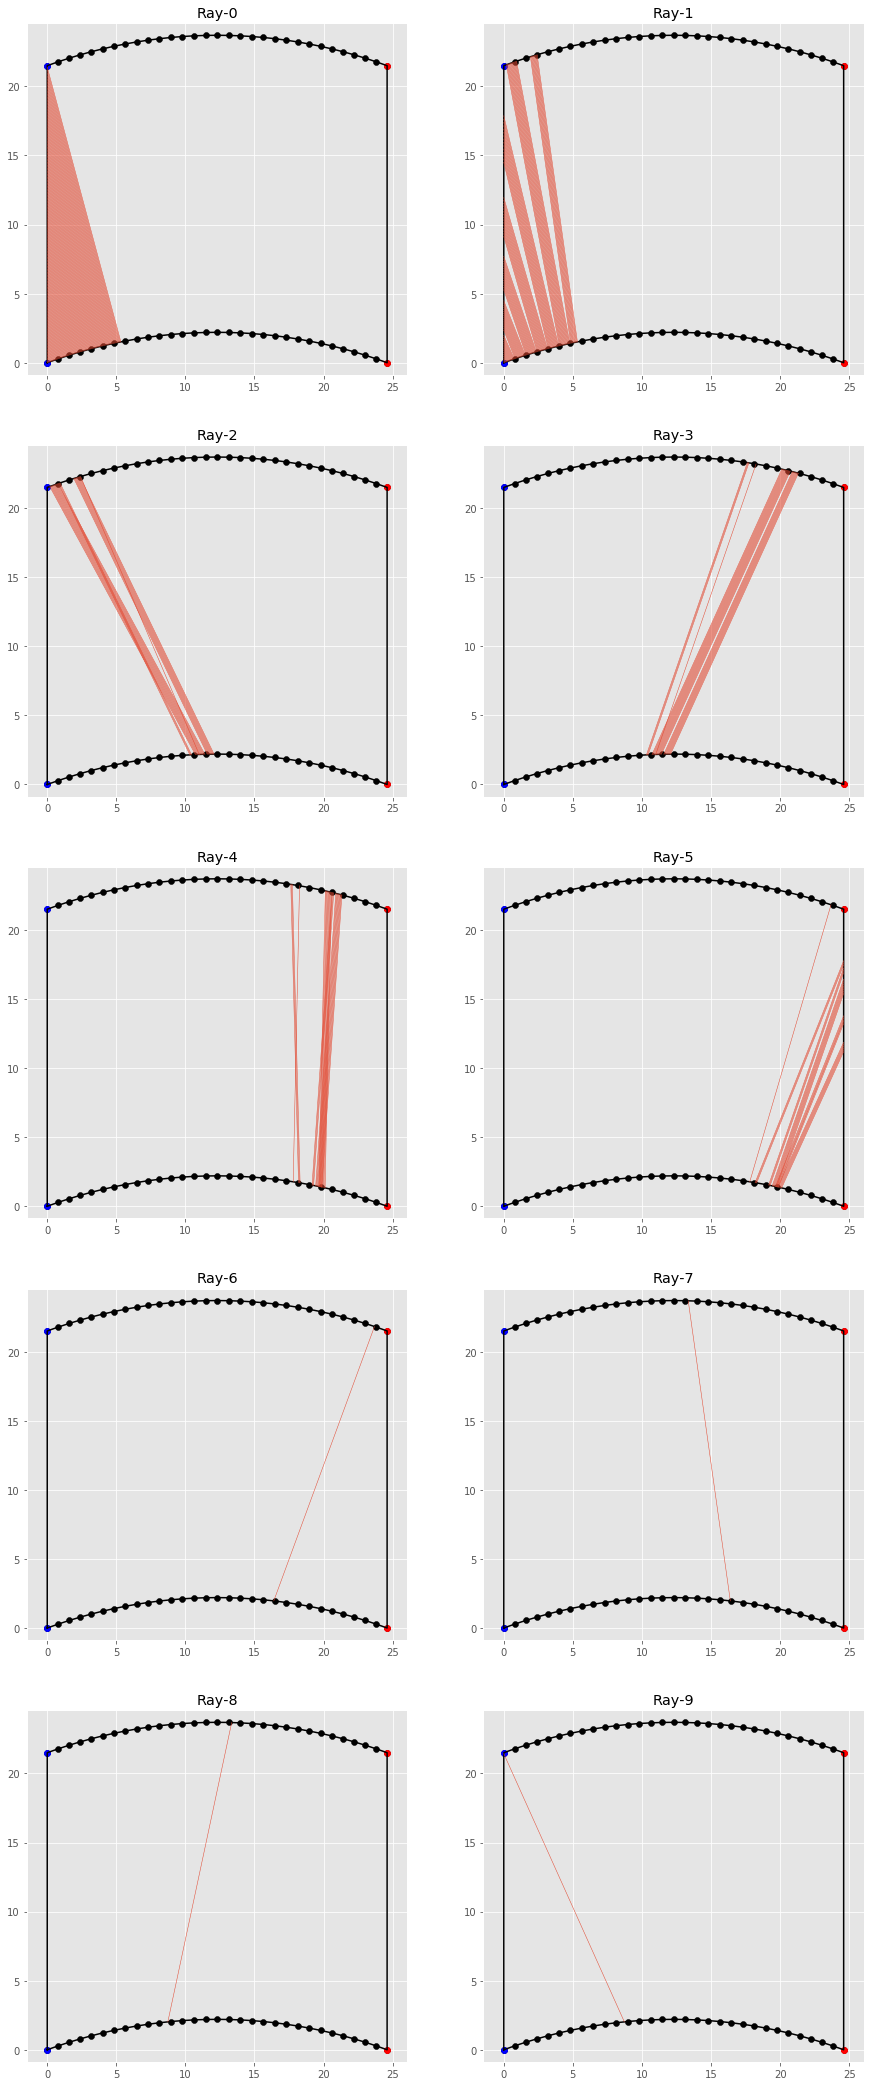

In [16]:
if __name__ == '__main__':
    
    psid = np.array([75., 45., 0., -45., -75.])
    phid = np.array([89., 75., 60., 45., 30., 15., 0., -15., -30., -45., -60., -75., -89.])
    refs = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    refd = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    
    #for i1 in range(len(psid)):#スラット角
    for i1 in range(2,3):#スラット角
        #for i2 in range(len(phid)):#プロファイル角
        for i2 in range(1,2):#プロファイル角
            #for i3 in range(22):#拡散反射率、正反射率
            for i3 in range(21,22):#拡散反射率、正反射率
                if 0 <= i3 and i3 <= 10:
                    refsd = refs[0]
                    refdd = refd[i3]
                elif 11 <= i3 and i3 <= 21:
                    refsd = refs[i3-11]
                    refdd = refd[0]
    
                #hbl_input( W, d, S, REFUS, REFUD, REFLS, REFLD, psi, phi )
                #hbl = hbl_input( 24.6, 2.2, 21.5, 0., 1., 0., 1., 45., 0. )#d<0未考慮, dが大きすぎると下のスラットを貫通する場合がある
                hbl = hbl_input( 24.6, 2.2, 21.5, refsd, refdd, refsd, refdd, psid[i1], phid[i2] )

                # W：スラット幅 (mm)
                # d：スラット高さ (mm) 
                # S：スラット間隔 (mm) 
                # REFUS：スラット材上面の日射反射率（鏡面反射成分）
                # REFUD：スラット材上面の日射反射率（拡散反射成分）
                # REFLS：スラット材下面の日射反射率（鏡面反射成分）
                # REFLD：スラット材下面の日射反射率（拡散反射成分）
                # psi：スラット角 (°) 
                # phi：プロファイル角 (°)

                #K = np.array([10, 10, 10, 10])       #領域境界の微小線分要素分割数(各境界)
                for i4 in range(5,6):
                    K = np.array([5*(i4+1), 1, 5*(i4+1), 1])          #領域境界の微小線分要素分割数(各境界)
                    M = 100                               #入射開口の微小線分要素分割数
                    lmax = 100                            #最大反射回数

                    A = slat_edge_position(hbl)[0]
                    B = slat_edge_position(hbl)[1]
                    C = slat_edge_position(hbl)[2]
                    D = slat_edge_position(hbl)[3]
                    E = slat_edge_position(hbl)[4]
                    F = slat_edge_position(hbl)[5]

                    O = slat_circle(hbl, A, B, E)[0]
                    r = slat_circle(hbl, A, B, E)[1]
                    theta = slat_circle(hbl, A, B, E)[2]

                    Ad = slat_additional_position(hbl, O, r, A, B)[0]
                    Bd = slat_additional_position(hbl, O, r, A, B)[1]
                    Cd = slat_additional_position(hbl, O, r, A, B)[2]
                    Dd = slat_additional_position(hbl, O, r, A, B)[3]

                    if hbl.d == 0: 
                        q = position_vector_flat_q(hbl, K)[0]
                        sK = position_vector_flat_q(hbl, K)[1]
                    elif hbl.d != 0:
                        qd = position_vector_curve_qd(hbl, K, O, r, theta, A, B, C, D, Ad, Bd, Cd, Dd)

                        out_pt = position_specific_qd(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd)[0]
                        in_pt = position_specific_qd(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd)[1]

                        q = position_vector_curve_q(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt)[0]
                        sK = position_vector_curve_q(hbl, K, qd, A, B, C, D, Ad, Bd, Cd, Dd, out_pt, in_pt)[1]

                    v = direction_vector(q)[0]
                    u = direction_vector(q)[1]

                    tau_t = through_transmission(hbl, M, q, v, u, sK)
                    tau_s = specular_reflection(hbl, M, q, v, u, lmax, sK)[0]
                    rho_s = specular_reflection(hbl, M, q, v, u, lmax, sK)[1]
                    tau_d = diffuse_reflection(hbl, M, q, v, u, sK)[0]
                    rho_d = diffuse_reflection(hbl, M, q, v, u, sK)[1]

                    tau_tot = total_optical_prop(tau_t, tau_s, tau_d, rho_s, rho_d)[0]
                    rho_tot = total_optical_prop(tau_t, tau_s, tau_d, rho_s, rho_d)[1]

                    print(psid[i1], phid[i2], refdd, refsd, refdd, refsd, tau_tot, rho_tot)
                    #print(tau_t, tau_s, tau_d, rho_s, rho_d)
                    #print(psid[i1], phid[i2], refdd, refsd, refdd, refsd, tau_t) #直接透過のみ

                    #for i in range(sK[len(sK) - 1]):
                    #    print(q[i])
                    #print (sK)
                    #print (sK[len(sK) - 2])

                    #'''
                    p = specular_reflection(hbl, M, q, v, u, lmax, sK)[2]
                    s = specular_reflection(hbl, M, q, v, u, lmax, sK)[3]

                    l = specular_reflection(hbl, M, q, v, u, lmax, sK)[4]

                    #グラフの描画
                    gx = np.empty((M, lmax, 2), dtype=object)
                    gy = np.empty((M, lmax, 2), dtype=object)
                    for ll in range(l):
                        for m in range(M):
                            gx[m][ll] = [p[m][ll][0], p[m][ll + 1][0]]
                            gy[m][ll] = [p[m][ll][1], p[m][ll + 1][1]]      


                    #l = 2
                    ax = np.empty(l, dtype = np.object)
                    fig = plt.figure(figsize = (15, 7.5 * ((l + 1) // 2)))
                    plt.style.use('ggplot')

                    for ll in range(l):   
                        ax[ll] = fig.add_subplot((l+1) // 2, 2, ll + 1)
                        ax[ll].set_title('Ray-' + str(ll))
                        ax[ll].plot(q[:, 0], q[:, 1], color='k')
                        ax[ll].scatter(q[:, 0], q[:, 1], color='k')

                        ax[ll].scatter(A[0]-Ad[0], A[1]-Ad[1], color='b')
                        ax[ll].scatter(B[0]-Ad[0], B[1]-Ad[1], color='r')
                        ax[ll].scatter(C[0]-Ad[0], C[1]-Ad[1], color='r')
                        ax[ll].scatter(D[0]-Ad[0], D[1]-Ad[1], color='b')
                        ax[ll].scatter(Ad[0]-Ad[0], Ad[1]-Ad[1], color='b')
                        ax[ll].scatter(Bd[0]-Ad[0], Bd[1]-Ad[1], color='r')
                        ax[ll].scatter(Cd[0]-Ad[0], Cd[1]-Ad[1], color='r')
                        ax[ll].scatter(Dd[0]-Ad[0], Dd[1]-Ad[1], color='b')

                        for m in range(M):
                            ax[ll].plot(gx[m][ll], gy[m][ll], color='C0', linewidth=0.5)
                        #ax.scatter(p[:, 1, 0], p[:, 1, 1], color='C0')
                        plt.axis('equal')

                    plt.show()
                    #'''